In [582]:
import yfinance as yf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Set default seaborn figure size
sns.axes_style(rc={'figure.figsize': (10, 5)})


# ==== Marcos
BTC_ETF = "IBIT"

# =====
# Fetch [SYMBOL] data with a 1-minute interval
SYMBOLS = ["BTC-USD", BTC_ETF]
df = yf.download(SYMBOLS, interval="1m", period="5d")
df.dropna(inplace=True)
df.reset_index(inplace=True)


df['Date'] = df['Datetime'].dt.date

df.head()


[*********************100%***********************]  2 of 2 completed


Price                   Datetime          Close                      High  \
Ticker                                  BTC-USD       IBIT        BTC-USD   
0      2025-01-07 14:30:00+00:00  100748.257812  57.244999  100748.257812   
1      2025-01-07 14:31:00+00:00  100588.125000  57.310001  100588.125000   
2      2025-01-07 14:33:00+00:00  100677.382812  57.254101  100677.382812   
3      2025-01-07 14:35:00+00:00  100374.570312  57.128799  100374.570312   
4      2025-01-07 14:36:00+00:00  100459.132812  57.055000  100459.132812   

Price                        Low                      Open             \
Ticker       IBIT        BTC-USD       IBIT        BTC-USD       IBIT   
0       57.349998  100748.257812  57.215000  100748.257812  57.320999   
1       57.340000  100588.125000  57.220001  100588.125000  57.240002   
2       57.301201  100677.382812  57.240002  100677.382812  57.301201   
3       57.219299  100374.570312  57.070000  100374.570312  57.110001   
4       57.160000  100459.132812  57.035000  100459.132812  57.130001   

Price      Volume                   Date  
Ticker    BTC-USD       IBIT              
0             0.0  2613141.0  2025-01-07  
1       3264512.0    98381.0  2025-01-07  
2       7806976.0   116226.0  2025-01-07  
3             0.0   210402.0  2025-01-07  
4             0.0   105420.0  2025-01-07

In [583]:
df[['Log_Close_BTC', 'Log_Close_IBIT']] = df['Close'].map(np.log)

In [584]:
# df['dLR_IBIT']

df_by_Date = df.groupby('Date')
df['LR_BTC'] = df_by_Date['Log_Close_BTC'].diff() / (df_by_Date['Datetime'].diff().dt.seconds / 60)
df['LR_IBIT'] = df_by_Date['Log_Close_IBIT'].diff() / (df_by_Date['Datetime'].diff().dt.seconds / 60)

LR = df[['LR_BTC', 'LR_IBIT']].droplevel(1, axis=1)

In [585]:
LR[['s_BTC', 's_IBIT']] = df[['LR_BTC', 'LR_IBIT']].diff().map(abs)

<Axes: >

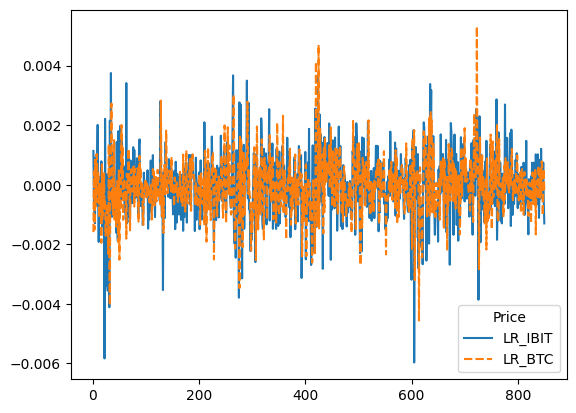

In [586]:
sns.lineplot(data=LR[['LR_IBIT', 'LR_BTC']])

Price
LR_IBIT   -0.000068
LR_BTC    -0.000052
dtype: float64

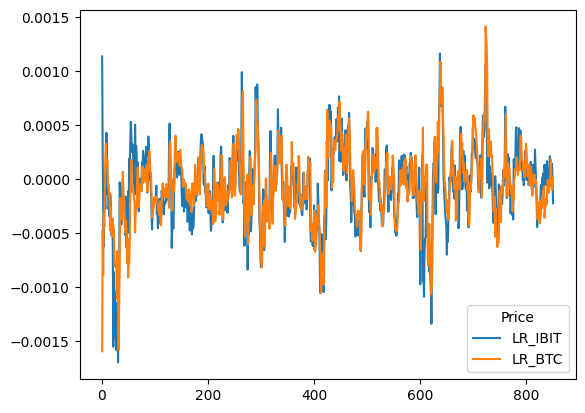

In [587]:
LR[['LR_IBIT', 'LR_BTC']].ewm(span=10).mean().plot()
LR[['LR_IBIT', 'LR_BTC']].ewm(span=10).mean().mean()

Price
s_IBIT    0.001248
s_BTC     0.000948
dtype: float64

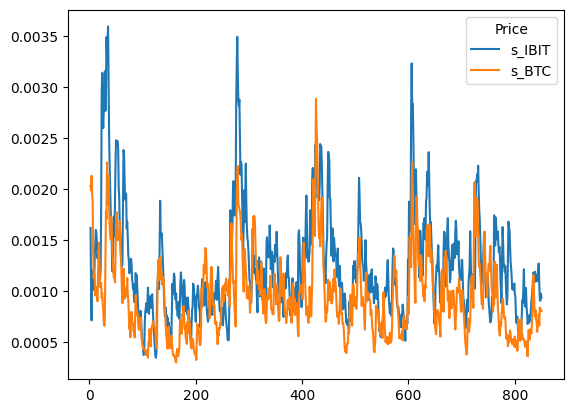

In [588]:
LR[['s_IBIT', 's_BTC']].ewm(span=10).mean().plot()
LR[['s_IBIT', 's_BTC']].ewm(span=10).mean().mean()

In [589]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pandas_datareader as pdr
import seaborn
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# Prepare the data for rolling regression
X = LR['LR_BTC']
Y = LR['LR_IBIT']

# Add a constant to the independent variable
X = sm.add_constant(X)

# Define the rolling window size
window_size = 3

# Fit the rolling OLS model
rolling_model = RollingOLS(Y, X, window=window_size)
rolling_results = rolling_model.fit()

# Extract the rolling coefficients
rolling_coefficients = rolling_results.params

/Users/shromannmajumder/Documents/Algorithimic Trading/.venv/lib/python3.13/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


<Axes: ylabel='Frequency'>

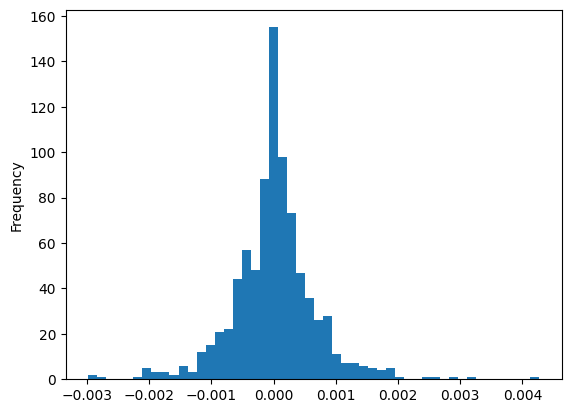

In [590]:
(LR['LR_IBIT'] - LR['LR_BTC'] * rolling_coefficients['LR_BTC'] - rolling_coefficients['const']).plot(kind='hist', bins=50)

Date
2025-01-07   -3.888252e-08
2025-01-08   -5.046050e-08
2025-01-10   -1.803603e-08
Name: Score, dtype: float64

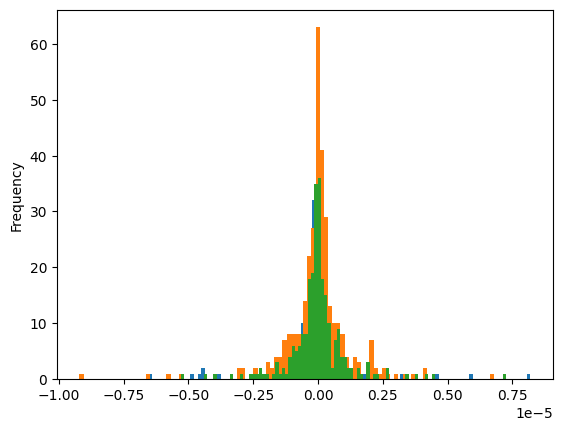

In [591]:
df['Pred'] = ((rolling_coefficients['LR_BTC'] * LR['LR_BTC']) + rolling_coefficients['const']).shift()
df['Score'] = df['Pred'] * df['LR_IBIT']

df.groupby('Date')['Score'].plot(kind='hist', bins=100)
df.groupby('Date')['Score'].mean()